In [2]:
!pip install -U layoutparser

     |████████████████████████████████| 19.1MB 1.2MB/s 
     |████████████████████████████████| 645kB 25.1MB/s 
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-wgahjch1/detectron2
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-wgahjch1/detectron2
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
     |████████████████████████████████| 51kB 3.5MB/s 
     |████████████████████████████████| 81kB 5.0MB/s 
     |████████████████████████████████| 112kB 37.0MB/s 
  Created wheel for detectron2: filename=detectron2-0.4-cp37-cp37m-linux_x86_64.whl size=5377819 sha256=b05742e82f0389f49c5c2f7583f4867f2e7bd304657d014658bf6bdb0cae0448
  Stored in directory: /tmp/pip-ephem-wheel-cache-6hz35dep/wheels/24/b4/77/2e5f8651761d4b6bd53b5e024a97583d9b043636c0c077ad4d
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=b973b7eeec05411f48627359dbc3a927c572e7ebf56c3aa6892d7fb26dca37aa
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df

In [4]:
!pip install layoutparser[ocr]     

     |████████████████████████████████| 440kB 4.9MB/s 
  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13953 sha256=c3431f92f0504bf742cff609c8cfdd7986fcfa4906b6be02e0fba44e86fd5151
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract


In [ ]:
!git clone https://github.com/Layout-Parser/layout-parser.git

In [2]:
%cd layout-parser/

/content/layout-parser


In [3]:
import cv2
image = cv2.imread("/content/layout-parser/examples/data/example-table.jpeg")
image = image[..., ::-1] 

config.yaml?dl=1: 8.19kB [00:01, 7.29kB/s]
model_final.pth?dl=1: 856MB [00:25, 34.2MB/s]                           


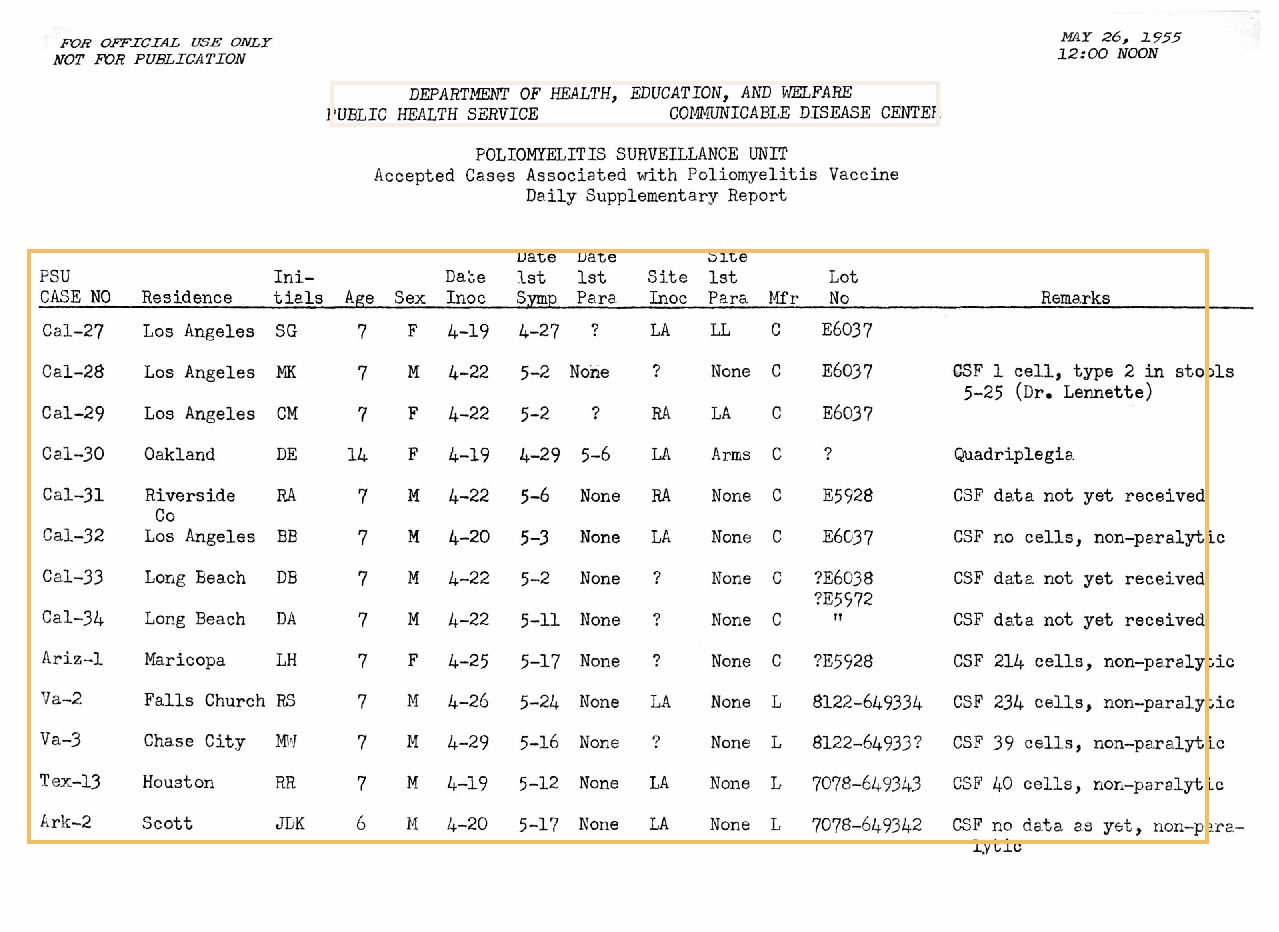

In [4]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

In [5]:
text_blocks = lp.Layout([b for b in layout if b.type=="Table"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=27.745590209960938, y_1=249.892578125, x_2=1208.9000244140625, y_2=843.3308715820312), text=None, id=None, type=Table, parent=None, next=None, score=0.9762899279594421)], page_data={})

In [6]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [ ]:
figure_blocks

In [7]:

text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [8]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

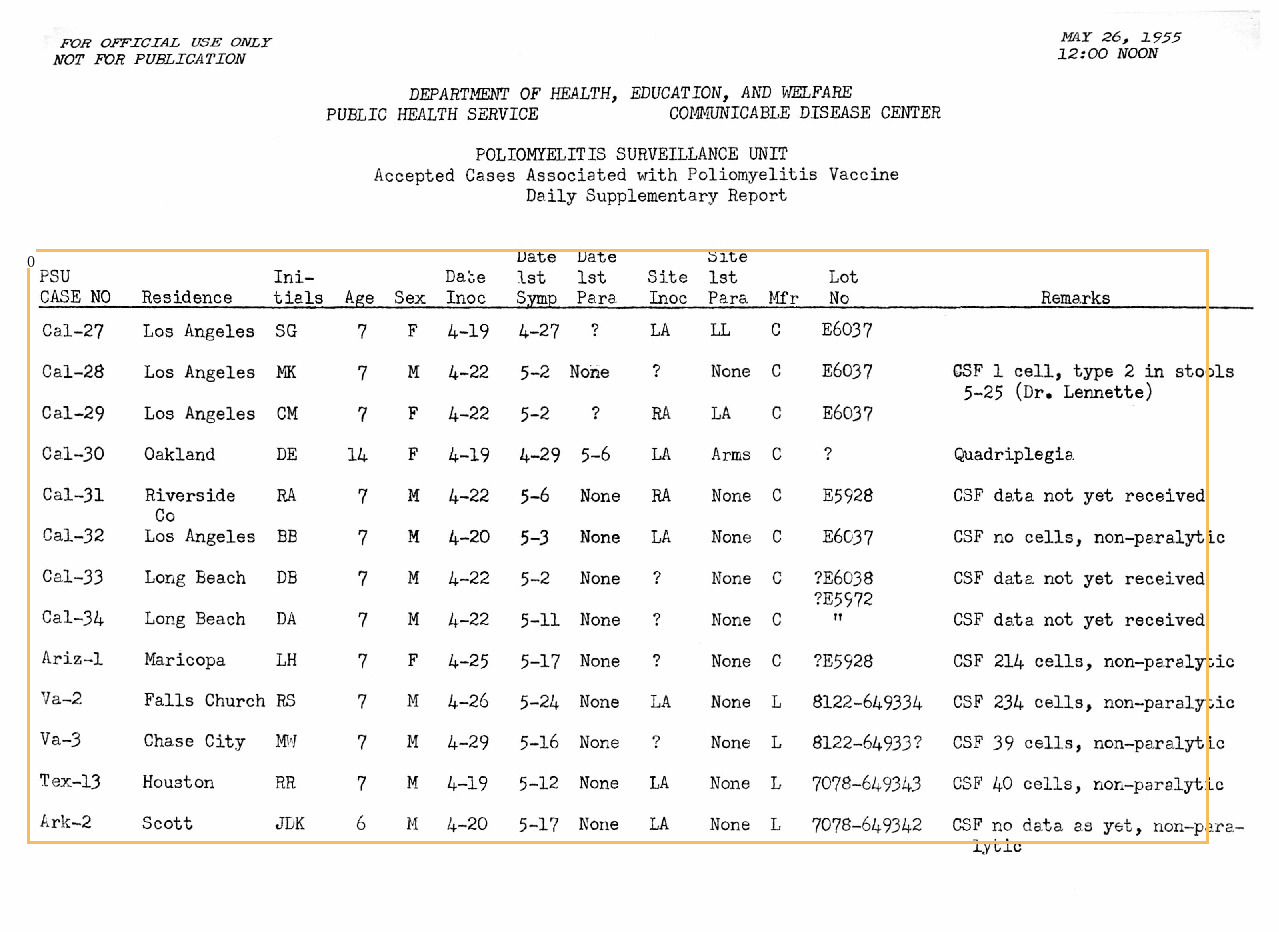

In [9]:

lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [10]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [11]:
!sudo apt install tesseract-ocr


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,150 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [12]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [13]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

 

Date Date Site
PSU Ini- Date Ast lst ist Lot
CASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks
Cal-27 Los Angeles SG F419 4-27? LL £6037
Cal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc

5-25 (Dr. Lennette)

Cal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037
Cal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia
Cal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received
Cal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;
Gel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received
Cal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received
Ariz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt
Va-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt
Va-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti
Tex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—parelyti
Ark~2 Scott DK 

In [ ]:
text_blocks.get_texts()

In [ ]:
for block in text_blocks:
  print(block)

In [ ]:
!pip install spacy

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [ ]:
!pip install click==7.1.1

In [ ]:
import spacy
nlp = spacy.load("en_core_web_trf")


In [ ]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [ ]:
".".join(sentence)  

In [ ]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)